In [1]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
PATH1 = '/content/drive/My Drive/Dataset/'

## Dataset Overview

In [4]:
df = pd.read_csv(PATH1+'fer2013.csv')

In [5]:
#check usage values
#80% training, 10% validation and 10% test
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
df.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [7]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = df['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


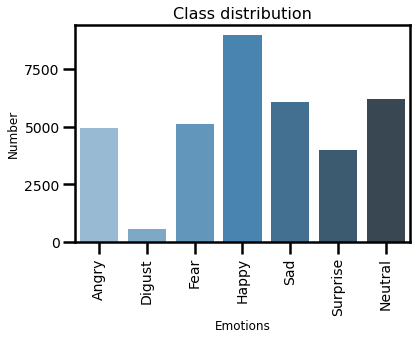

In [27]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number, palette=("Blues_d"))
sns.set_context("poster")
plt.title('Class distribution', fontsize=16)
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

## Pre processing

In [9]:
train_samples = df[df['Usage']=="Training"]
validation_samples = df[df["Usage"]=="PublicTest"]
test_samples = df[df["Usage"]=="PrivateTest"]

Train - Val - Test split

In [10]:
y_train = train_samples.emotion.astype(np.int32).values
y_valid = validation_samples.emotion.astype(np.int32).values
y_test = test_samples.emotion.astype(np.int32).values
  
X_train =np.array([ np.fromstring(image, np.uint8, sep=" ").reshape((48,48)) for image in train_samples.pixels])
X_valid =np.array([ np.fromstring(image, np.uint8, sep=" ").reshape((48,48)) for image in validation_samples.pixels])
X_test =np.array([ np.fromstring(image, np.uint8, sep=" ").reshape((48,48)) for image in test_samples.pixels])

Normalisation

In [12]:
X_train_std = X_train/255.
X_valid_std = X_valid/255.
X_test_std = X_test/255.

## Building CNN Model

CNN Model Architecture:


*   Conv2D -> BN -> Activation -> MaxPooling -> Dropout
*   Conv2D -> BN -> Activation -> MaxPooling -> Dropout
*   Conv2D -> BN -> Activation -> MaxPooling -> Dropout
*   Conv2D -> BN -> Activation -> MaxPooling -> Dropout
*   Conv2D -> BN -> Activation -> MaxPooling -> Dropout
*   Flatten
*   Dense -> BN -> Activation -> Dropout
*   Dense -> BN -> Activation -> Dropout
*   Output Layer







In [13]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(64,(3,3), input_shape=(48,48, 1), padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(128,(5,5), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(256,(3,3), padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.20))

model.add(keras.layers.Conv2D(512,(3,3), padding="same"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(256,(3,3), activation='relu',padding="same"))
model.add(keras.layers.Conv2D(128,(3,3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.25))

#model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(7,activation='softmax'))


In [14]:
#Compiling the model

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(lr=0.005) , metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

In [16]:
#fit the model
history = model.fit(X_train_std, y_train,batch_size=64,epochs=35, validation_data=(X_valid_std, y_valid), shuffle=True)

history_dict = history.history
history_dict.keys()

Epoch 1/35
449/449 [==============================] - 55s 54ms/step - loss: 2.2462 - accuracy: 0.2114 - val_loss: 1.8289 - val_accuracy: 0.2591
Epoch 2/35
449/449 [==============================] - 23s 51ms/step - loss: 1.8505 - accuracy: 0.2564 - val_loss: 1.6573 - val_accuracy: 0.3396
Epoch 3/35
449/449 [==============================] - 23s 51ms/step - loss: 1.6076 - accuracy: 0.3580 - val_loss: 1.4630 - val_accuracy: 0.4124
Epoch 4/35
449/449 [==============================] - 23s 51ms/step - loss: 1.4872 - accuracy: 0.4017 - val_loss: 1.3797 - val_accuracy: 0.4402
Epoch 5/35
449/449 [==============================] - 23s 51ms/step - loss: 1.3957 - accuracy: 0.4386 - val_loss: 1.3733 - val_accuracy: 0.4600
Epoch 6/35
449/449 [==============================] - 23s 51ms/step - loss: 1.3126 - accuracy: 0.4908 - val_loss: 1.2852 - val_accuracy: 0.4957
Epoch 7/35
449/449 [==============================] - 23s 51ms/step - loss: 1.2566 - accuracy: 0.5136 - val_loss: 1.3144 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [18]:
loss_values = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(acc) +1)

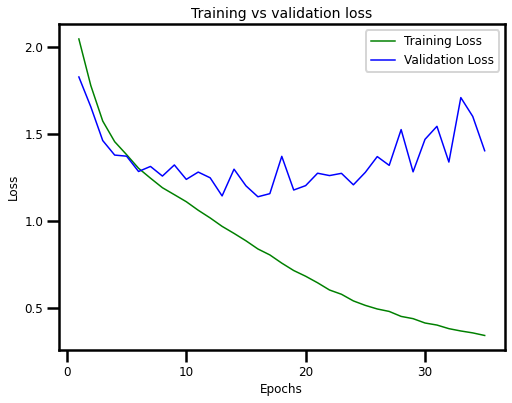

In [47]:
#plotting the training and validation loss
plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'g', label = 'Training Loss', linewidth=1.5)
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss', linewidth = 1.5)
plt.title('Training vs validation loss', fontsize=14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Loss', fontsize = 12)
plt.legend(fontsize = 12)

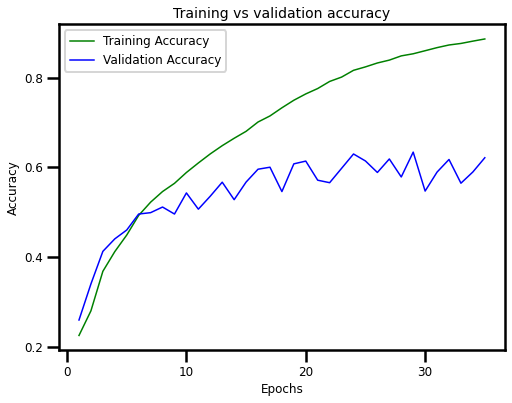

In [48]:
#plotting the training and validation accuracy
plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'g', label = 'Training Accuracy', linewidth=1.5)
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy', linewidth=1.5)
plt.title('Training vs validation accuracy', fontsize=14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize=12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend(fontsize = 12)

In [45]:
test_acc = model.evaluate(X_test_std,y_test)
print('Testing accuracy: ', test_acc)

113/113 [==============================] - 2s 11ms/step - loss: 1.3160 - accuracy: 0.6406
Testing accuracy:  [1.3160483837127686, 0.6405683755874634]
